In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    





/home/cd/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
### Load classifer
from sklearn.externals import joblib
#model_name = 'acc0.9875_HLS_orient9pix_per_cell8cell_per_block2spatial_size(16, 16)hist_bin32.pkl'
model_name = 'acc0.9912_YCrCb_orient9pix_per_cell8cell_per_block2spatial_size(16, 16)hist_bin32.pkl'
clf = joblib.load(model_name)
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# load scaler
import pickle
pkl_file = open('scaler_'+ model_name, 'rb')
X_scaler = pickle.load(pkl_file)

In [4]:
def multi_scale_sliding_window(img, nr_interpolation):
    
    

    # interpolation 
    x_starts = np.linspace(0, 0, nr_interpolation , )
    x_stops  = np.linspace(1280,1280,nr_interpolation )
    window_sizes = np.linspace(220, 50, nr_interpolation)
    y_starts = np.linspace(450, 380, nr_interpolation)
    
    x_starts = x_starts.astype(np.int)
    x_stops  = x_stops.astype(np.int)
    window_sizes = window_sizes.astype(np.int)
    y_starts = y_starts.astype(np.int)
    # y_stops  = np.linspace(400, 500, nr_interpolation)
    scaled_windows = []
    for x_start, x_stop, window_size, y_start in zip(x_starts, x_stops, window_sizes, y_starts):
        # 
        nr_window = 1280 / window_size
        window_size = 1280 / int(nr_window)
        window_size = int(window_size)
        windows = slide_window(image, x_start_stop=[x_start, x_stop], y_start_stop=[y_start, y_start+window_size], 
                    xy_window=(window_size, window_size), xy_overlap=(0.6, 0.6))
        scaled_windows = scaled_windows + windows
    return scaled_windows
    

In [5]:
def vehicle_detection(image, draw_image):
    windows = multi_scale_sliding_window(image, 8)

    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       


    window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

    #window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=2)                    

    return (window_img, hot_windows)

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img


In [7]:
class Detector():
    
    def __init__(self):
        self.bb_list = []
        self.queue_nr = 5
        self.labels = None
        
    def add_bounding_box(self, bbs ):
        # print ('Nr. bbox current', len(bbs))

        if len(self.bb_list) > self.queue_nr:
            self.bb_list.pop(0)
        self.bb_list.append(bbs)
        
    def generate_heat_map(self, heat ,threshold):        
        flatten = lambda l: [item for sublist in l for item in sublist]
        windows = flatten(self.bb_list)
        print ('Nr. bbox total', len(windows))
        heat = add_heat(heat, windows)
        heat = apply_threshold(heat,threshold )
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        self.labels = label(heatmap)
        return heatmap
        
    def getResult(self, image):
        draw_img = None
        if self.labels != None:
            draw_img = draw_labeled_bboxes(np.copy(image), self.labels)
        return draw_img

In [15]:
def process_image(image):
    draw_image  = np.copy(image)
    draw_image_result  = np.copy(image)
    image = image.astype(np.float32)/255
    (window_img, hotwindows) = vehicle_detection(image, draw_image)
    #(window_img, hotwindows)  =  multi_scale_hog_sub_sample_find_car(image, draw_image )
    detector.add_bounding_box(hotwindows)
    heat = np.zeros_like(image[:,:,0]).astype(np.uint)
    heatmap = detector.generate_heat_map(heat, 5)  
    result_img = detector.getResult(draw_image_result) 
    return (  result_img )
    # return ( heatmap, result_img )

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, draw_img, ystart, ystop, nysteps, color_space, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    # draw_img = np.copy(img)
    # draw_img = draw_img.astype(np.uint)*255
    # img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    #print ('nxblocks {} = ({} // {}) - {} + 1'.format(nxblocks, ch1.shape[1], pix_per_cell,cell_per_block))
    #print ('nyblocks {} = ({} // {}) - {} + 1'.format(nyblocks, ch1.shape[0], pix_per_cell,cell_per_block))

    
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 6  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    # nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # nysteps = 2
    
    #print ('nblocks_per_window', nblocks_per_window)
    #print ('nxsteps {} = ({}  - {}) // {}'.format(nxsteps, nxblocks, nblocks_per_window,cells_per_step))
    #print ('nysteps {} = ({}  - {}) // {}'.format(nysteps, nyblocks, nblocks_per_window, cells_per_step))
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hot_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),5) 
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))  )
            else:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),2) 

                
    return (draw_img, hot_windows)

In [10]:
def multi_scale_hog_sub_sample_find_car(image, draw_image ):
    
    scaled_windows = []
    ystart = 400
    ystop = 720
    scale = 1
    (window_img, windows1) = find_cars(image, draw_image,  ystart, ystop, 2, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 1.5
    (window_img, windows2) = find_cars(image, window_img,  ystart, ystop, 2, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 2
    (window_img, windows3) = find_cars(image, window_img,  ystart, ystop, 1,color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 3
    (window_img, windows4) = find_cars(image, window_img,  ystart, ystop, 1, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 4
    (window_img, windows5) = find_cars(image, window_img,  ystart, ystop, 1, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scaled_windows+=windows1
    scaled_windows+=windows2
    scaled_windows+=windows3
    scaled_windows+=windows4
    scaled_windows+=windows5

    
    return (window_img, scaled_windows) 

### Test vehicle detection on single image

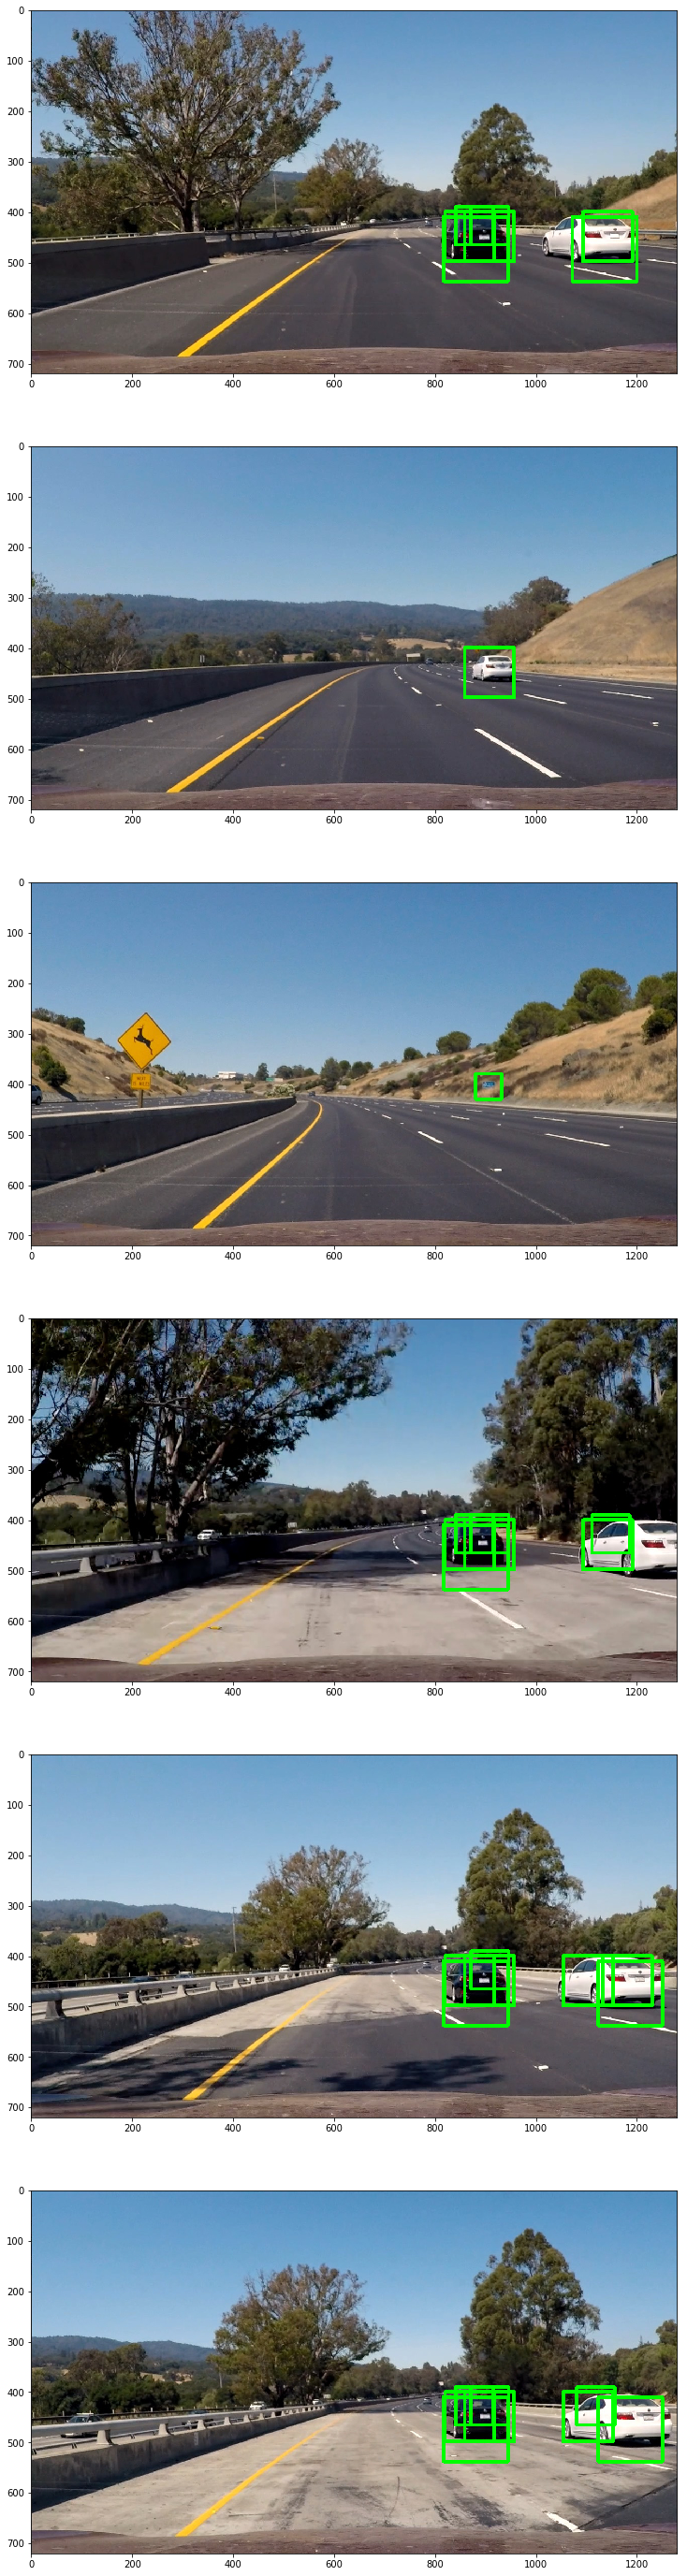

In [11]:
test_images = glob.glob('test_images/*.jpg')
plt.figure(1, figsize=(50,50))

plot_num = len(test_images)
it = 1
# parameter for find_cars
ystart = 400
ystop = 720
scale = 3
for file in test_images:
    # Read in each one by one
    image = mpimg.imread(file)
    draw_image  = np.copy(image)  
    image = image.astype(np.float32)/255
    (window_img, windows) = vehicle_detection(image, draw_image)
    #               find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #(window_img, windows)  =  multi_scale_hog_sub_sample_find_car(image, draw_image )
    #window_img = find_cars(image, draw_image, ystart, ystop, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    
    
    plt.subplot(plot_num,1,it)
    plt.imshow(window_img)
    it+=1
    
    
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
 

#window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    
# window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)                    

plt.show()

In [12]:
from moviepy.editor import VideoFileClip

# load 
#white_output = 'test_video_out.mp4'
#clip1 = VideoFileClip("test_video.mp4")

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

In [ ]:
detector = Detector()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


### Test on video clip

In [ ]:
white_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")

detector = Detector()
i = 0
frame_begin = 0
frame_end = 10
scale = 2

outputs = []
heatmaps = []
for frame in clip1.iter_frames():
    if (i >= frame_begin and i < frame_end ):
        print ('process frame ', i)
         
        image = np.asarray(frame)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print (np.max(image_rgb))
        image_draw =  np.copy(image)
        (heatmap, output) = process_image(image_rgb)
        # output = find_cars(image_rgb, ystart, ystop, color_space, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        # (output, hot_windows)  =  multi_scale_hog_sub_sample_find_car(image_rgb, image_rgb )
        # print (len(hot_windows))
        outputs.append(output)
        heatmaps.append(heatmap)
        

    i = i + 1

### Generate Head map

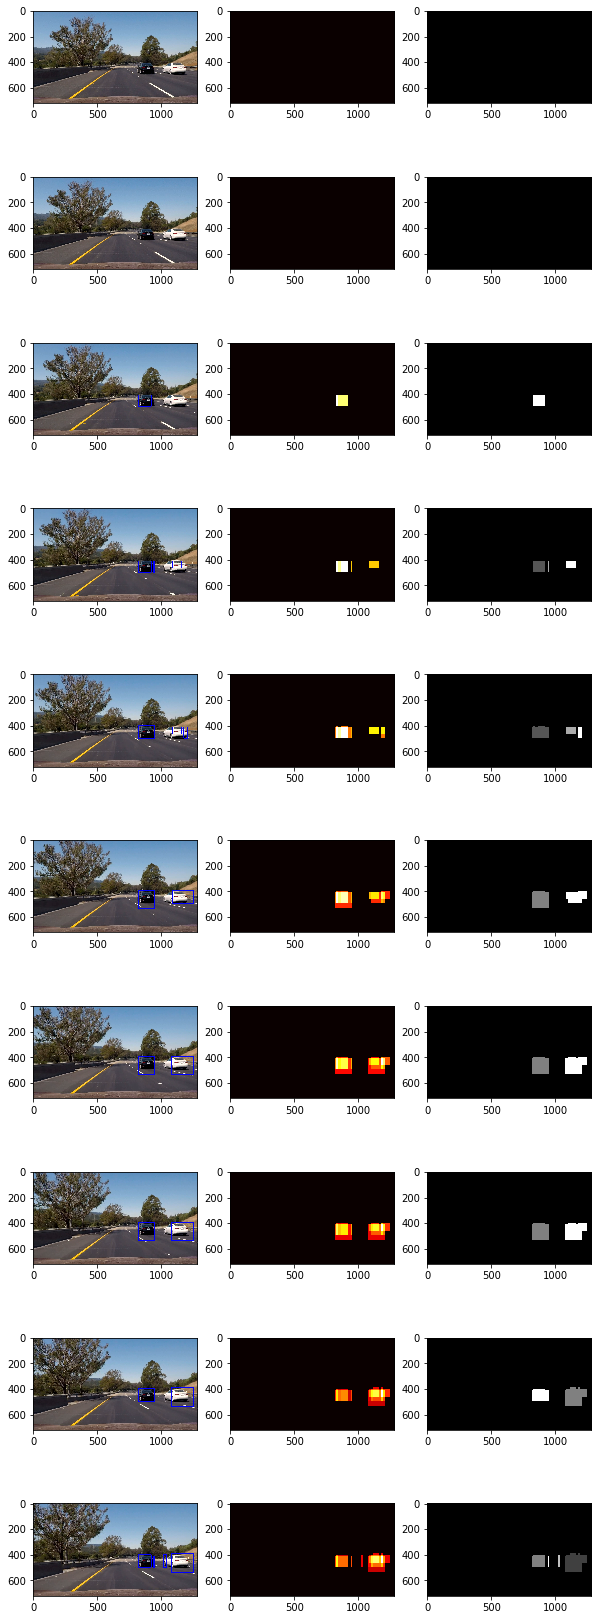

In [71]:
plt.figure(1, figsize=(10,30))

i = 0
for heat_map, output in zip(heatmaps, outputs):   
    plt.subplot(10,3,3*i + 1)
    heat_map = heat_map.astype(np.uint)
    heat_rgb = np.zeros_like(output[:,:,:])
    heat_rgb[:,:,0] = heat_map
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_RGB2BGR)) 
    plt.subplot(10,3,3*i +2)
    plt.imshow(heat_map , cmap='hot')
    plt.subplot(10,3,3*i +3)
    labels = label(heat_map)
    plt.imshow(labels[0], cmap='gray')

    i+=1
plt.show()